# Python Keras Handout - CBOW Model

D-590 Fall 2024

NLP

Olga Scrivner & Siddharth Gosawi

**CBOW model** predicts the _current word_ given context words within _specific window_.

     - The input layer contains the context words
     - The hidden layer contains the number of dimensions in which
        we want to represent the current word presented at the output layer
     - The output layer contains the current word


![Mikolov et al., 2013](https://static.packt-cdn.com/products/9781786465825/graphics/B05525_03_05.jpg)

There are actually three frameworks to build CBOW model:

### **tensorflow**
- developed by Google researchers
- designed to be used with python or javascript
- python version can be installed via PYPI (pip)
    - see documentation (license, release) - https://pypi.org/project/tensorflow/

### **keras**

- a neural network library (using tensoflow and theanos functionalities)
- developed by a Google engineer François Chollet
- designed to make implementing deep learning models as fast and easy as possible for research and development
- requires tensoflow or theanos installation
    - keras library can be installed via PYPI (pip)
- see documentation (license, release) - https://pypi.org/project/keras/

### **pytorch**

- developed by facebook
- allows for dynamic models deep learning
        -  tensorflow/keras build static models
        -  models have to be built from the beginning and then re-used
    - can be installed via PYPI (pip)
- see documentation - https://pypi.org/project/torch/

To build CBOW model we will be using a Python interface to Keras with tensorflow serving as a "backend engine".
- Keras is a Python library for developing and evaluating deep learning models
- TensorFlow is an open-source symbolic tensor manipulation framework developed by Google: [link](http://www.tensorflow.org/)
- Keras uses the TensorFlow backend by default

In [1]:
# import keras.backend as K # K for Keras, just a common abbreviation
import tensorflow.keras.backend as K # K for Keras, just a common abbreviation

**Sequential model** is used when you have One Input and One output

In [2]:
from keras.models import Sequential



Keras provides pre-built layers for different neural network architecture.
- **Dense**
    - _Dense Layer_ is used for creating a deeply connected layer where each of the neurons of the dense layers receives input from all neurons of the previous layer.
- **Embedding**
   - _Embedding layer_ is a compression of the output and is used to embed higher dimensional data into lower dimensional vector space
- **Lambda**
   - _Lambda Layer_ is used for _transforming_ input using an expression or function.



In [3]:
from keras.layers import Dense, Embedding, Lambda

1. First you create a sequential constructor (similar to CountVectorizer() etc)

In [4]:
cbow = Sequential()

2. Then you can add layers to Sequential Contstructor using .add() and compile model with .compile()

## LAYER 1: Embedding Layer

The Embedding layer generate weights. The output is a 2D vector with one embedding for each word .

Embedding layer requires several arguments:

- **input_dim**: We need to know $\color{red}{vocabulary \: size}$. `input_dim` should equal size of vocabulary + 1
- **output_dim**: We need to select a $\color{red}{dimension \: size}$ for the dense embedding. This is the size of the vector space into which words will be embedded.
       - when the layer is smaller , you compress more and lose more data.
       - When the layer is bigger, you compress less and potentially overfit your input dataset to this layer.
       - The larger vocabulary you have you want better representation of it - make the layer larger.
       - If you have very sparse documents relatively to the vocabulary, then you want to "get rid" of unnecessary and
          noisy words - you should compress more - make the embedding smaller.

- **input_length**: Length of input sequences, when it is constant. In CBOW model, we use $\color{red}{size \: of \: window*2}$




To generate `input_dim`, we need to build a vocabulary maping:
- extract each unique word from corpus vocabulary and map a unique numeric identifier to it.

Keras provides a utility for text preprocesssing `from keras.preprocessing import text` ([see description of all functionalities](https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/text.py)).
- `Tokenizer()` is a class with several methods:
    - `fit_on_texts`  - updates internal vocabulary based on a list of texts
    - `word_index` - create a dictionary with words and their indices:
           dict(zip(sorted_voc, list(range(1, len(sorted_voc) + 1)))) # from documentation (see link above)



We are going tto create a small corpus for illustration purpose.

In [5]:
import numpy as np
import nltk
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Using a small example
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'
]
corpus = np.array(corpus)
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(corpus)

In [7]:
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

We will now import necessary keras library to generate vocabulary mapping for CBOW.

In [8]:
# from keras.preprocessing import text
from tensorflow.keras.preprocessing import text


In [9]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_corpus)
word2id = tokenizer.word_index
word2id['PAD'] = 0

Note: word2id creates a map of word and its index (unique identifier). Index always start with 1. "sky" is the first token after preprocessing.

In [10]:
word2id

{'sky': 1,
 'blue': 2,
 'beautiful': 3,
 'quick': 4,
 'brown': 5,
 'fox': 6,
 'lazy': 7,
 'dog': 8,
 'love': 9,
 'sausages': 10,
 'ham': 11,
 'bacon': 12,
 'eggs': 13,
 'jumps': 14,
 'kings': 15,
 'breakfast': 16,
 'toast': 17,
 'beans': 18,
 'green': 19,
 'today': 20,
 'PAD': 0}

We also need to create a reverse mapping from Index to Word `id2word` and word mapping to their sentences `wids`

In [11]:
vocab_size = len(word2id)
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_corpus]
print("Vocabulary size", vocab_size)
print("Index to Word")
print(id2word)
print("Index to Sentence")
print(wids)

Vocabulary size 21
Index to Word
{1: 'sky', 2: 'blue', 3: 'beautiful', 4: 'quick', 5: 'brown', 6: 'fox', 7: 'lazy', 8: 'dog', 9: 'love', 10: 'sausages', 11: 'ham', 12: 'bacon', 13: 'eggs', 14: 'jumps', 15: 'kings', 16: 'breakfast', 17: 'toast', 18: 'beans', 19: 'green', 20: 'today', 0: 'PAD'}
Index to Sentence
[[1, 2, 3], [9, 2, 3, 1], [4, 5, 6, 14, 7, 8], [15, 16, 10, 11, 12, 13, 17, 18], [9, 19, 13, 11, 10, 12], [5, 6, 4, 2, 8, 7], [1, 2, 1, 3, 20], [8, 7, 5, 6, 4]]


Padding is typically used to pad context words to a fixed length if needed. Most neural networks require the input sequence data with **the same length** so we need **padding**: to truncate or pad sequence (pad with 0s) into the same length.

        - Notice that Index starts always with "1" because "0" is reserved for padding.
 Figure  below shows how zeros are added to shorter sequences to keep the same length for all sequences (sentences) and the first sequences is truncated aat the beginning.     

![](https://miro.medium.com/max/1750/1*CPLhZoVSTCWgAxe2LKXoOA.png)
source: https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633





`pad_sequence()` function from keras.preprocessing.sequence allows to add padding at the beggining (padding='pre') or at the end of the sequence (padding = 'post'). If the maximum length (`maxlen`) is not defined, it will take the size of the longuest sequence.

In [12]:
from keras.preprocessing import sequence
from keras.utils import pad_sequences

In [13]:
# max_length = 4 # you can try changing maximum length for padding
padded_docs = pad_sequences(wids,  padding='pre') # maxlen=max_length,
print(padded_docs)

[[ 0  0  0  0  0  1  2  3]
 [ 0  0  0  0  9  2  3  1]
 [ 0  0  4  5  6 14  7  8]
 [15 16 10 11 12 13 17 18]
 [ 0  0  9 19 13 11 10 12]
 [ 0  0  5  6  4  2  8  7]
 [ 0  0  0  1  2  1  3 20]
 [ 0  0  0  8  7  5  6  4]]


Finally we need to import keras utility helper function `from keras.utils import np_utils` (numpy related utility [link]{https://www.kite.com/python/docs/keras.utils.np_utils})

In [14]:
from tensorflow.python.keras.utils import np_utils

- We will be choosing our context window size = 2. Window size depends how many words on the left and right we want to include.
- We will choose embedding size = 100. Our matrix will be vocabulary size x embeddeding size. This will be ouur output dimension (read ta the top about how to choose embedding size = `output_dim`)

In [15]:
embed_size = 100
window_size = 2

The embedding layer is added to Sequential() Constructor with the following parameters:
- input dimension = vocabulary size (20),
- output ddimension = embedding size (100), a hyper-parameter
- input length = window context (2*2 = 4)

In [16]:
# cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size))

- **Input Shape** = 4 x 100 (4,100).
- **Output shape** = (None, 4, 100), where the first value represent **batch** size.
    - `None` means the size/dimension is variable but each sample in the batch will always have a shape 4x100. So output is (None, 4,100)
    - If `batch size` is defined, then it is the subset size of your training sample (e.g. 100 out of 1000)

## LAYER 2: Lambda Layer

Lambda is a wrapper for your function. For example, if you wanted to build a layer that squares its input, you could state:

`model.add(lambda(lambda x: x ** 2))`

In our case, Lambda layer will return the average of weights `mean`. Axis value specifies the axis along which the means are computed: **1** = along the column. The output dimention will be 100 (1-dimension).




In [17]:
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))


## LAYER 3: Dense Layer

Dense layer is a neural network layer that is fully connected:  each neuron in the dense layer receives input from all neurons of its previous layer

- **unit** is the output size (just a positive integer)
    - we use vocab size = 20 as output size
- **activation** represents the activation function (e.g. softmax, sigmoid, ReLU)
    - we use `softmax` which converts a vector of values to a probability distribution: output vector values are in range (0, 1) and sum to 1.


In [18]:
cbow.add(Dense(vocab_size, activation='softmax'))


### Compile Method

Compile method configures the learning process. For the list of available optimizers [see link](https://faroit.com/keras-docs/1.1.0/optimizers/)

- **RMSprop Optimizer**: RMSprop is a gradient-based optimization technique used in training neural networks. This normalization balances the step size (momentum), decreasing the step for large gradients to avoid exploding and increasing the step for small gradients to avoid vanishing [see link](https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be)

- **Categorical Crossentropy** is used to compute the crossentropy loss between the labels and predictions.
   - Crossentropy is a measure of the difference between two probability distributions



In [19]:
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
cbow.build(input_shape=(None, window_size*2))


Using `model.summary()` we can see an overview of the model architecture.

Each layer has an output and its shape is shown in the “Output Shape” column. Each layer’s output becomes the input for the subsequent layer.

The “Param #” column shows you the number of parameters that are trained for each layer.

Initial input is 1 x Vocabulary (a vector of size 21)

- Embedding Layer
  - The input layer will take a 2-D matrix of shape (None, 21) which means that each sample must be reshaped into a vector of 21 elements.
  - The output layer will be 3-D matrix of shape (None, 4, 100)
  - The number of parameters will be 21 x 100 = 2100
- Lambda Layer (averaging weights)
  - The input will take the output from Embedding layer (3-D matrix)
  - The output is 2-D matrix (None, 100), each batch sample must be shaped into a vector of 100 elements. Since Lambda is simply wrapping the function, there is no parameters.
- Dense Layer
  - The input is 2-D matrix from Lambda layer
  - The output is 2-D matrix (None, 21) with sample batches as a vector of 20 elements (vocabulary size)
  - The number of parameters = 100x21 plus number of biases for each node = 2121

In [20]:
print(cbow.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 4, 100)              │           2,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 21)                  │           2,121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,221 (16.49 KB)

 Trainable params: 4,221 (16.49 KB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
# for layer in cbow.layers:
#   print(layer.name, input_shape)
for layer in cbow.layers:
    input_shape = K.int_shape(layer.input)
    print(layer.name, input_shape)

embedding (None, 4)
lambda (None, 4, 100)
dense (None, 100)


## Generating Context pairs for CBOW Model

Our function uses np_utils to convert vectors back to input matrix and sequence.pad_sequence to add zeros if the context length < 4.

In [22]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        #print(words)
        for index, word in enumerate(words):
            #print(index,word)
            context_words = []
            label_word   = []
            start = index - window_size
            end = index + window_size + 1

            context_words.append([words[i]
                                 for i in range(start, end)
                                 if 0 <= i < sentence_length
                                 and i != index])
            label_word.append(word)
            #print(word)
            x = pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [23]:
i = 0
for x, y in generate_context_word_pairs(corpus=padded_docs, window_size=window_size, vocab_size=vocab_size):
    print(x,y)
    if 0 not in x[0]:
        print(np.argwhere(y[0])[0][0])
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
        #print(id2word[np.argwhere(y[0])[0][0]])
        if i == 10:
            break
        i += 1

[[0 0 0 0]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 0 0]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 0 0]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 0 1]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 1 2]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 2 3]] [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 1 3]] [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 1 2]] [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 0 0]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 0 0]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 0 9]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 9 2]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0 2 3]] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.

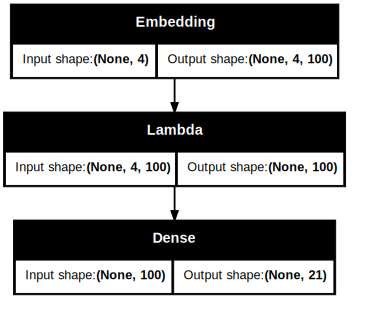

In [24]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

#display(SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False,
   #              rankdir='TB', dpi=65).create(prog='dot', format='svg'))) # use dpi to reduce size of the image

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False,
rankdir='TB', dpi=65).create(prog='dot', format='svg'))

### Training

- **Epoch** is the number of passes over the data
- **Loss** is the error over the training set
- The lower loss value, the better

In [25]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=padded_docs, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 10 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 10 (context, word) pairs
Processed 20 (context, word) pairs
Processed 30 (context, word) pairs
Processed 40 (context, word) pairs
Processed 50 (context, word) pairs
Processed 60 (context, word) pairs
Epoch: 1 	Loss: 190.0151083469391

Processed 10 (context, word) pairs
Processed 20 (context, word) pairs
Processed 30 (context, word) pairs
Processed 40 (context, word) pairs
Processed 50 (context, word) pairs
Processed 60 (context, word) pairs
Epoch: 2 	Loss: 182.72244691848755

Processed 10 (context, word) pairs
Processed 20 (context, word) pairs
Processed 30 (context, word) pairs
Processed 40 (context, word) pairs
Processed 50 (context, word) pairs
Processed 60 (context, word) pairs
Epoch: 3 	Loss: 174.18082356452942

Processed 10 (context, word) pairs
Processed 20 (context, word) pairs
Processed 30 (context, word) pairs
Processed 40 (context, word) pairs
Processed 50 (context, word) pairs
Processed 60 (context, word) pairs
Epoch: 4 	Loss: 166.622713804245

Processed 10 (conte

### Word Embeddings

In [26]:
import pandas as pd
weights = cbow.get_weights()[0]
weights = weights[1:]
print("Matrix Shape: ", weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

Matrix Shape:  (20, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
blue,-0.076501,0.029894,-0.011570,0.011102,-0.029992,-0.096430,0.080132,0.062998,-0.041141,-0.054155,...,0.016111,-0.000824,-0.035780,0.023506,0.032977,-0.084966,0.098195,0.002915,-0.048796,0.014309
beautiful,0.002116,0.027616,-0.014997,0.033669,0.025789,0.006309,0.092553,-0.006395,-0.027339,0.028614,...,0.017629,0.037911,-0.012956,0.019173,-0.043351,0.046808,0.029186,-0.023649,-0.023404,-0.086183
quick,-0.043192,0.051912,0.027199,0.019034,-0.070214,-0.108553,0.041518,-0.025373,0.114055,0.030910,...,-0.072342,0.095504,-0.034126,0.033947,0.015687,-0.048809,0.091568,0.001981,0.022970,-0.029967
brown,0.001223,0.012266,-0.039873,0.023260,-0.048432,0.024857,-0.067200,0.066255,-0.003667,-0.096556,...,0.096428,-0.008556,-0.123557,0.010775,0.045516,-0.041226,0.012991,0.019498,-0.033269,-0.061553
fox,0.024175,-0.011714,-0.082073,-0.023409,0.035770,0.050246,-0.026845,0.087967,-0.019296,-0.068626,...,-0.010911,0.057695,-0.117854,0.021435,-0.002695,0.068406,-0.063331,0.054215,-0.000422,-0.008547


In [27]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                   for search_term in ['quick', 'fox']}

similar_words

(20, 20)


{'quick': ['lazy', 'jumps', 'green', 'beans', 'today'],
 'fox': ['dog', 'jumps', 'toast', 'beans', 'kings']}